In [23]:
from Preprocessing import ImagePreprocessing
from Processing import FrangiFilter2D
from Postprocessing import ImagePostprocessing
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from ImageLoader import ImageLoader
import os

image_dir = "images/"
image_paths = [os.path.join(image_dir, "pictures", fname) for fname in os.listdir(os.path.join(image_dir, "pictures"))]
labels_paths = [
    os.path.join(image_dir, "manual", os.path.basename(p).replace(".JPG", ".tif").replace(".jpg", ".tif"))
    for p in image_paths
]

masks_paths = [
    os.path.join(image_dir, "mask", os.path.basename(p).replace(".JPG", "_mask.tif").replace(".jpg", "_mask.tif"))
    for p in image_paths
]

images = ImageLoader.load_images(image_paths)
labels = ImageLoader.load_images(labels_paths)
masks = ImageLoader.load_images(masks_paths)

images = np.stack(images)
labels = np.stack(labels)
masks = np.stack(masks)

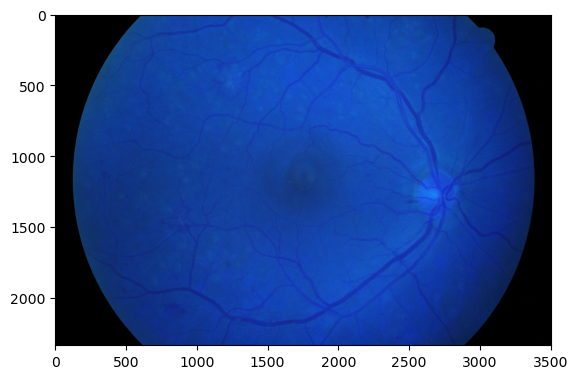

In [25]:
plt.imshow(images[1])

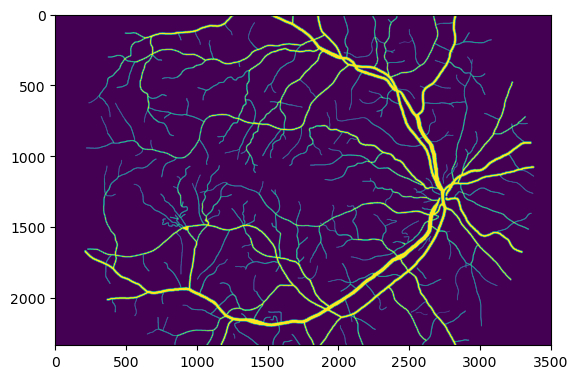

In [26]:
plt.imshow(labels[1])

In [27]:
print(images.shape)

(45, 2336, 3504, 3)


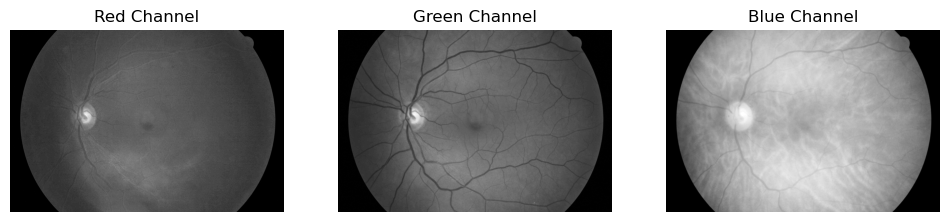

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
channels = ['Red', 'Green', 'Blue']
for i in range(3):
    axes[i].imshow(images[0, :, :, i], cmap='gray')
    axes[i].set_title(f'{channels[i]} Channel')
    axes[i].axis('off')
plt.show()

In [29]:
green = ImagePreprocessing.extract_green_channel(images[0:5])
clahe = ImagePreprocessing.apply_clahe(green[0:5])
median = ImagePreprocessing.median_filter(clahe[0:5])
normalized = ImagePreprocessing.normalize(median[0:5])

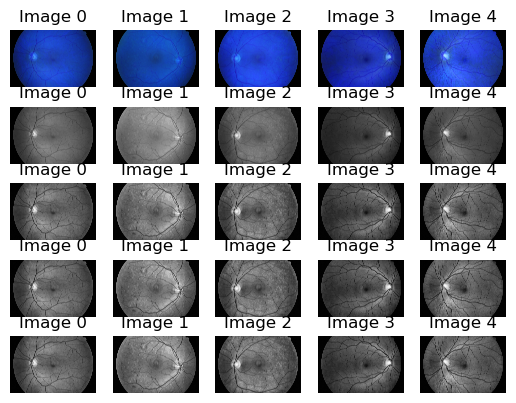

In [30]:
import matplotlib.pyplot as plt

# Preview the first 5 images from the green array
num_images = 5
fig, axes = plt.subplots(5, num_images)
for i in range(num_images):
    axes[0,i].imshow(images[i], cmap='gray')
    axes[0,i].set_title(f'Image {i}')
    axes[0,i].axis('off')

for i in range(num_images):
    axes[1,i].imshow(green[i], cmap='gray')
    axes[1,i].set_title(f'Image {i}')
    axes[1,i].axis('off')

for i in range(num_images):
    axes[2,i].imshow(clahe[i], cmap='gray')
    axes[2,i].set_title(f'Image {i}')
    axes[2,i].axis('off')

for i in range(num_images):
    axes[3,i].imshow(median[i], cmap='gray')
    axes[3,i].set_title(f'Image {i}')
    axes[3,i].axis('off')

for i in range(num_images):
    axes[4,i].imshow(normalized[i], cmap='gray')
    axes[4,i].set_title(f'Image {i}')
    axes[4,i].axis('off')
plt.show()

In [31]:
resized_green = ImagePreprocessing.resize_and_normalize([green[0]])
resized_clahe = ImagePreprocessing.resize_and_normalize([clahe[0]])
resized_median = ImagePreprocessing.resize_and_normalize([median[0]])
resized_normalized = ImagePreprocessing.resize_and_normalize([normalized[0]])

In [32]:
frangi_green = FrangiFilter2D.apply(resized_green[0])
frangi_clahe = FrangiFilter2D.apply(resized_clahe[0])
frangi_median = FrangiFilter2D.apply(resized_median[0])
frangi_normalized = FrangiFilter2D.apply(resized_normalized[0])

/home/ania/Pulpit/Wykrywanie-naczy-dna-siatk-wki-oka/Processing.py:18: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  return frangi(


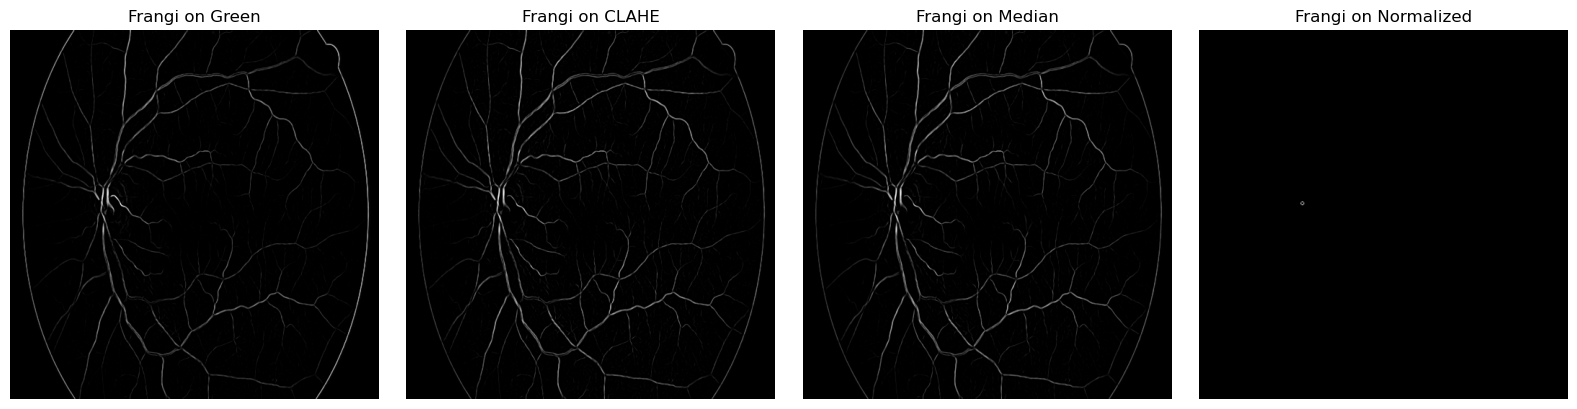

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
titles = ['Frangi on Green', 'Frangi on CLAHE', 'Frangi on Median', 'Frangi on Normalized']
images_to_plot = [frangi_green, frangi_clahe, frangi_median, frangi_normalized]

for ax, img, title in zip(axes, images_to_plot, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
binary = ImagePostprocessing.adaptive_binarization(frangi_median)
opened = ImagePostprocessing.morphological_opening(binary)
closed = ImagePostprocessing.morphological_closing(opened)
filtered = ImagePostprocessing.filter_small_objects(closed)
skeleton = ImagePostprocessing.skeletonize_image(filtered)
smoothed = ImagePostprocessing.smooth_contours(skeleton)  # Optional

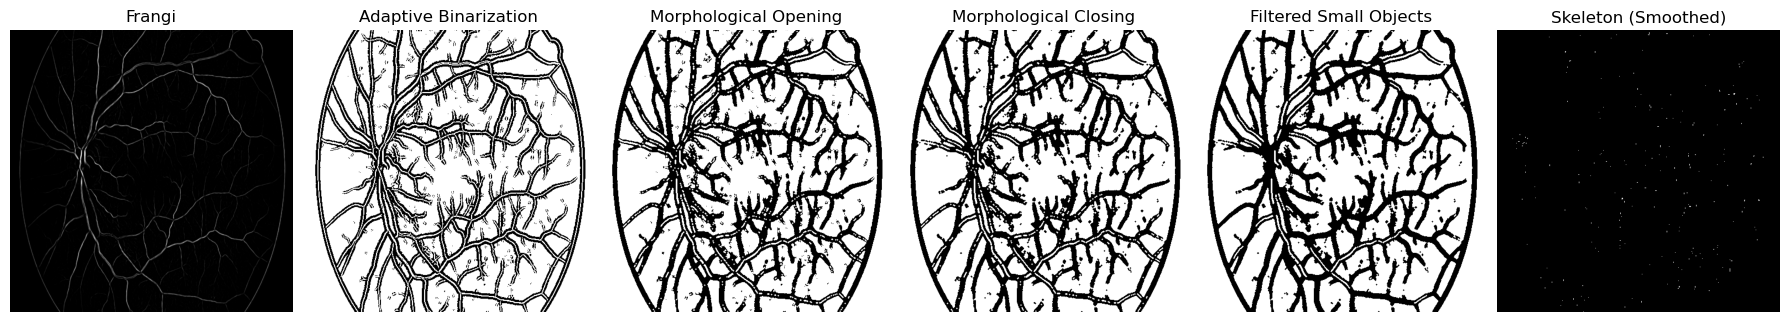

In [36]:
fig, axes = plt.subplots(1, 6, figsize=(18, 4))
titles = [
    "Frangi",
    "Adaptive Binarization",
    "Morphological Opening",
    "Morphological Closing",
    "Filtered Small Objects",
    "Skeleton (Smoothed)"
]
images_to_plot = [
    frangi_median,
    binary,
    opened,
    closed,
    filtered,
    smoothed
]

for ax, img, title in zip(axes, images_to_plot, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


(512, 512) (512, 512) (512, 512)


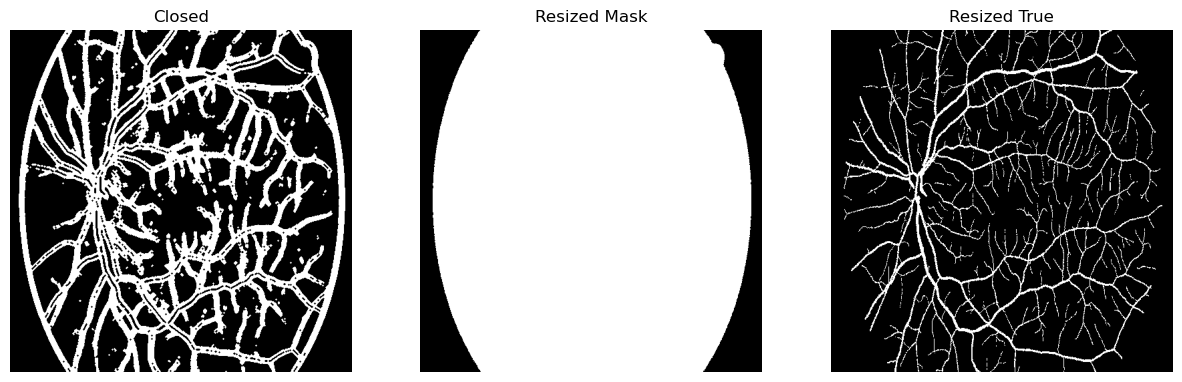

In [58]:
from Evaluator import Evaluator

resized_mask = ImagePreprocessing.resize_and_normalize([masks[0]])[0,:,:,1]
# Binarize resized_mask while preserving dimensions
resized_mask = (resized_mask > 0).astype(np.uint8)
resized_true = ImagePreprocessing.resize_and_normalize([labels[0]])[0]
resized_true = (resized_true > 0).astype(np.uint8)

closed = 1 - (closed // 255)

print(closed.shape, resized_mask.shape, resized_true.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(closed, cmap='gray')
axes[0].set_title('Closed')
axes[1].imshow(resized_mask, cmap='gray')
axes[1].set_title('Resized Mask')
axes[2].imshow(resized_true, cmap='gray')
axes[2].set_title('Resized True')
for ax in axes:
    ax.axis('off')
plt.show()

In [59]:
cm = Evaluator.confusion(resized_true, closed, resized_mask)

In [60]:
print(cm)

{'TN': 137734, 'FP': 59448, 'FN': 9667, 'TP': 14884}


In [61]:
acc = Evaluator.accuracy(resized_true, closed, resized_mask)
sens = Evaluator.sensitivity(resized_true, closed, resized_mask)
spec = Evaluator.specificity(resized_true, closed, resized_mask)

print(acc, sens, spec)

0.68829628426982 0.6062482179951937 0.6985120345670497
